In [1]:
import numpy as np
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift
from astropy.table import Table
from matplotlib import colors

In [2]:
# Set up paths 
frameSize = 351
band = 'L'
tg_name= '2M1207'
useRefFrames = False
path_input = './2M1207_bands/Lband/'
path_output = path_input + 'out/'
sep='/'
print(path_input)

path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

./2M1207_bands/Lband/


In [3]:
# File list
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['./2M1207_bands/Lband/sci/NACO.2004-04-27T03_46_03.306.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_46_39.244.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_47_16.051.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_47_52.368.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_48_28.143.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_49_04.621.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_49_41.248.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_50_18.238.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T03_50_55.397.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_16_45.617.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_17_21.705.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_17_57.125.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_18_33.419.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_19_10.408.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_19_45.998.fits', './2M1207_bands/Lband/sci/NACO.2004-04-27T04_20_22.634.fits', './2M12

In [4]:
filelist = []
filelist.extend(filelist_flats)
filelist.extend(filelist_flats_darks)
filelist.extend(filelist_sci)
filelist.extend(filelist_darks)
filelist = np.asarray(filelist)

In [5]:
def read_file(file_name):
    return fits.open(file_name)[0].data.astype(float)

def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()
    #plt.ylim(200,600)

In [6]:
Obslog = Table(
                    names=("File", "UTC", "objid", "exptime"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "float64"
                          )
                    )
for i in filelist:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE-OBS"], header_file["OBJECT"], header_file["EXPTIME"]]
      Obslog.add_row(row)


In [7]:
np.unique(Obslog["exptime"])

<Column name='exptime' dtype='float64' length=3>
0.175
  0.2
 30.0

In [8]:
fb_exptime = 0.2
s_exptime = 0.175
b_exptime = 30.0

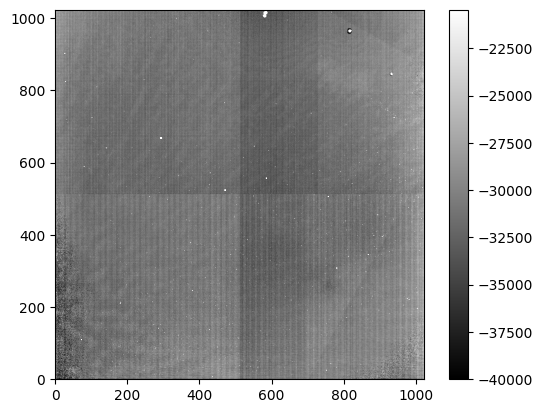

In [9]:
flats_darks = []
for i in filelist_flats_darks:
    flats_darks.append(read_file(i) / fb_exptime)
flats_darks = np.asarray(flats_darks)
flats_darks_master = np.median(flats_darks, axis = 0)
plot_data(flats_darks_master)
flats_darks_master_map = flats_darks_master + np.abs(np.min(flats_darks_master))
hot_pixel = flats_darks_master_map > 5 * np.median(flats_darks_master_map)

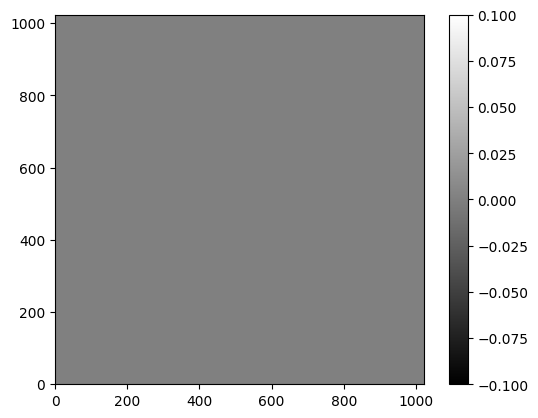

In [10]:
plt.imshow(hot_pixel, origin='lower', cmap='gray')
plt.colorbar()

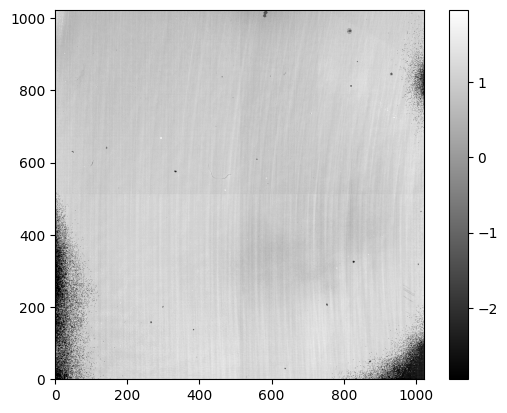

In [11]:
flats = []
for i in filelist_flats:
    flats.append(read_file(i) / fb_exptime)
flats = np.asarray(flats)
flats_master = np.median(flats, axis = 0)
flats_master_norm = flats_master / np.median(flats_master)
plot_data(flats_master_norm)
cold_pixel = flats_master_norm < 0.7

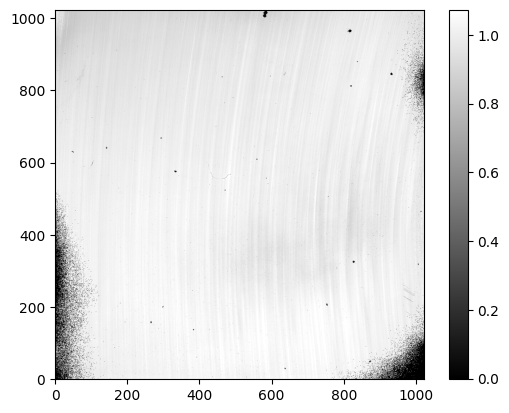

In [12]:
#plot_data(flats_master - flats_darks_master)
true_master_flat = (flats_master - flats_darks_master) / np.median(flats_master - flats_darks_master)
plot_data(true_master_flat)

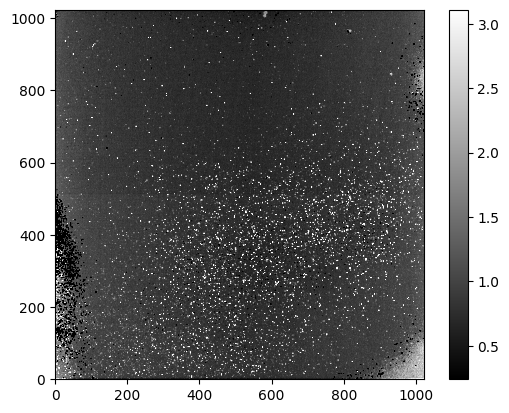

In [13]:
sci_darks = []
for i in filelist_darks:
    sci_darks.append(read_file(i) / b_exptime)
sci_darks = np.asarray(sci_darks)
sci_darks_master = np.median(sci_darks, axis = 0)
plot_data(sci_darks_master)

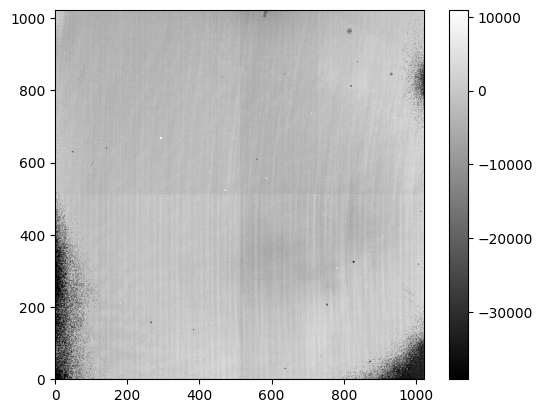

In [14]:
sci = []
for i in filelist_sci:
    sci.append(read_file(i) / s_exptime)
sci = np.asarray(sci)
plot_data(sci[0])

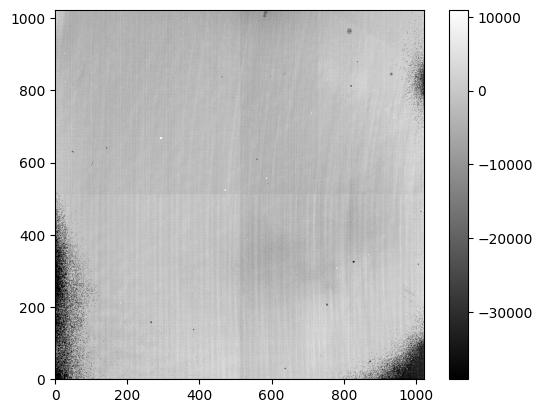

In [15]:
plot_data(sci[0] - sci_darks_master)

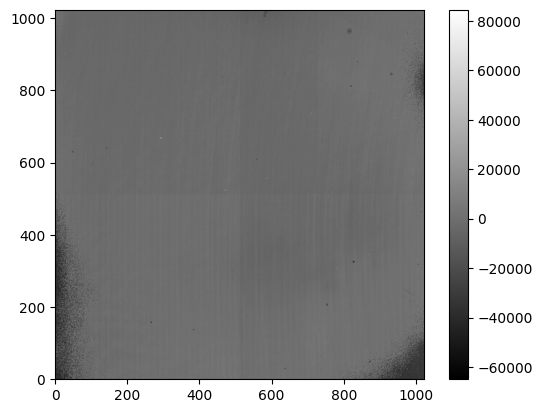

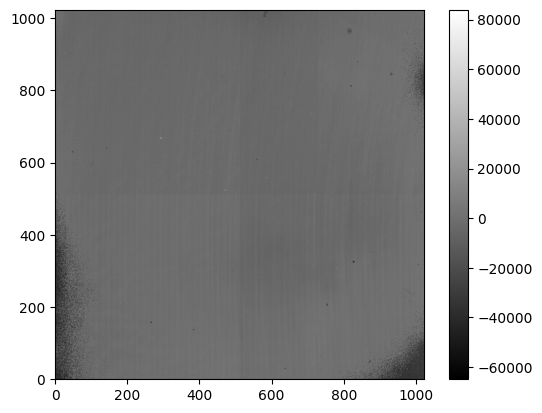

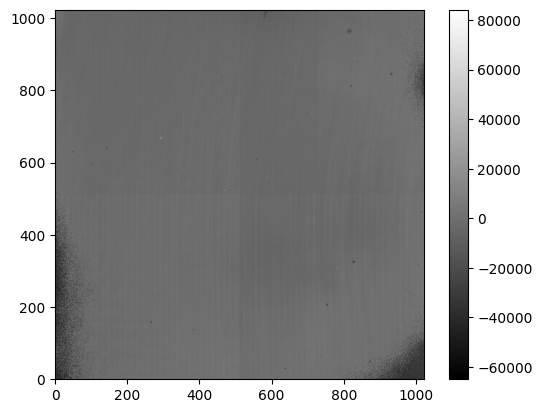

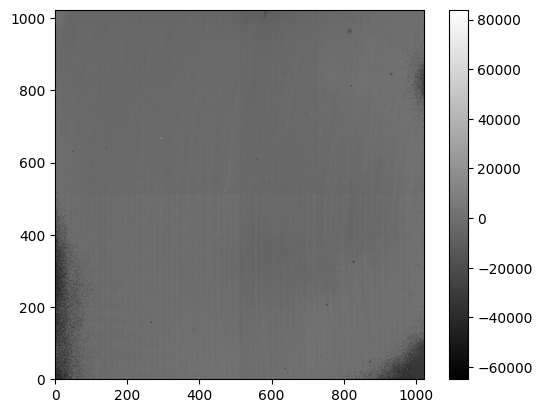

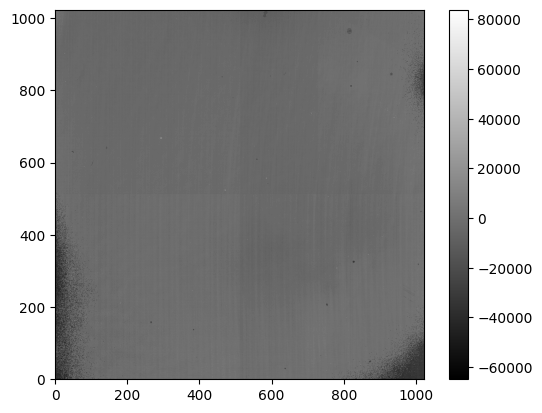

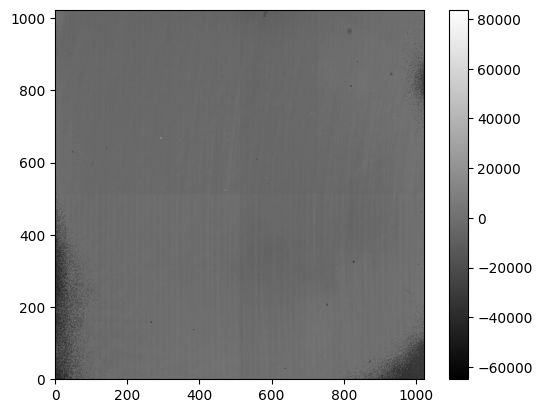

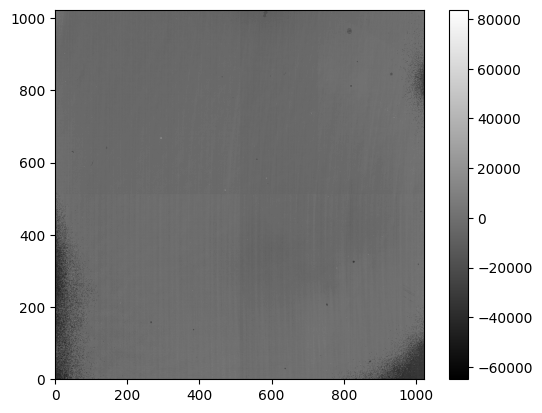

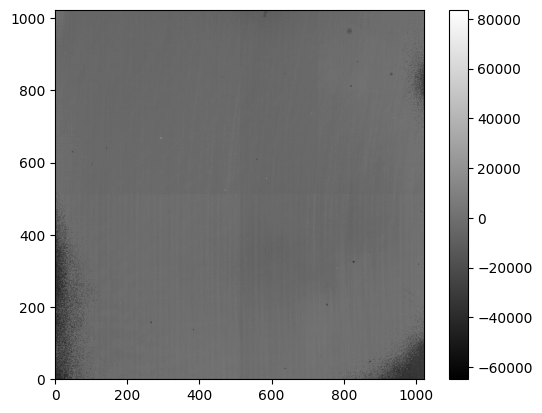

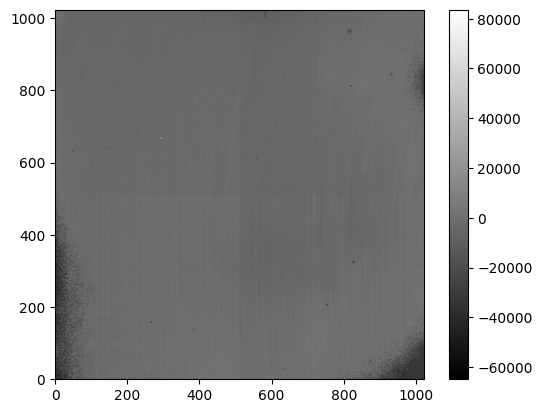

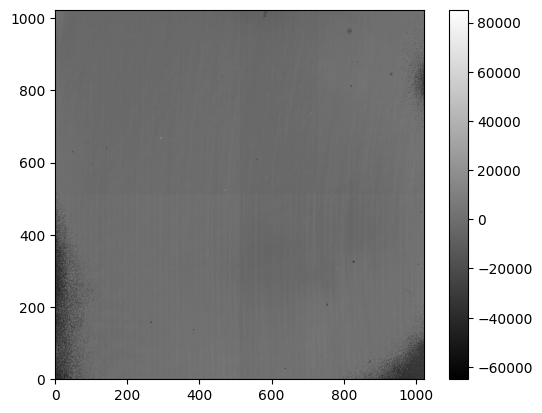

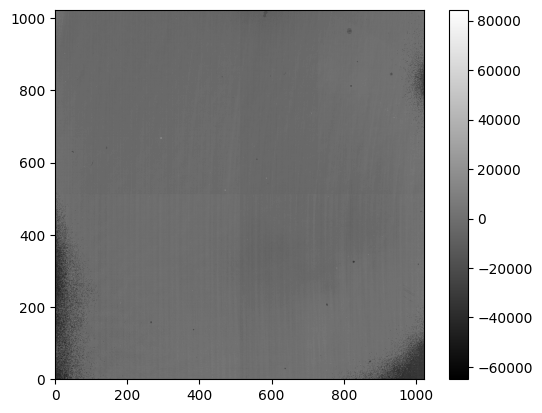

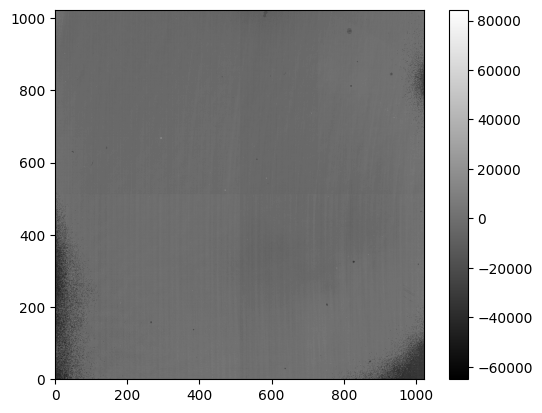

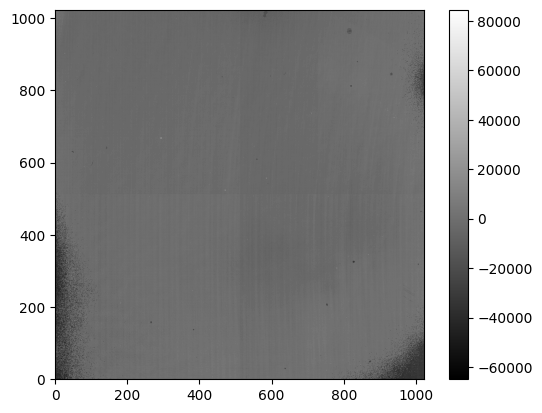

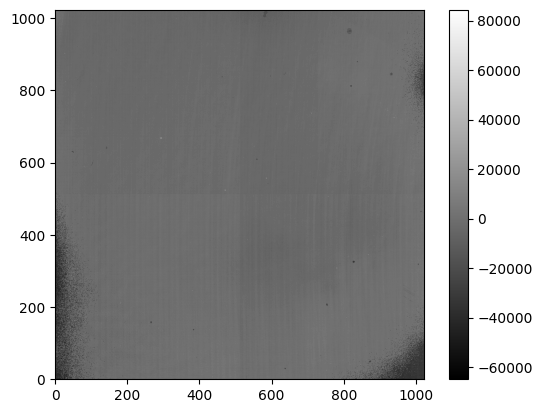

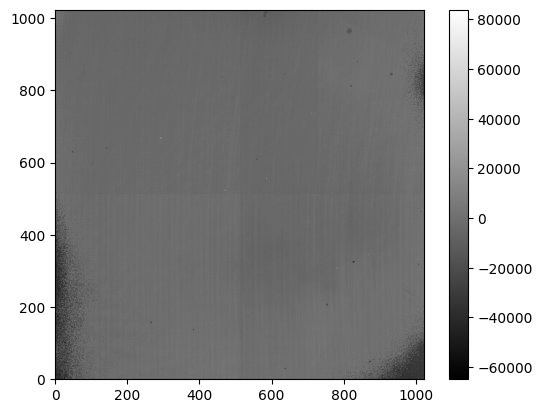

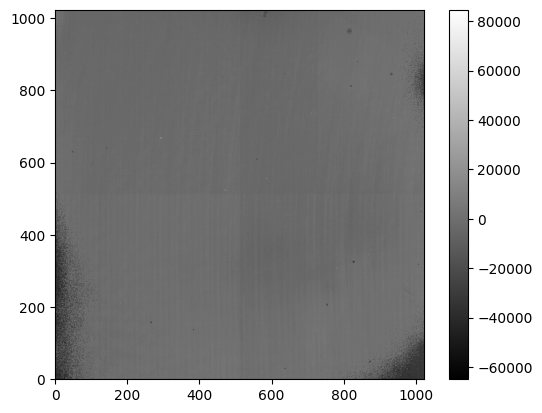

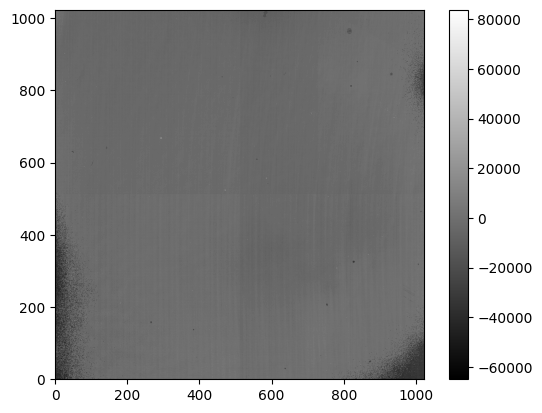

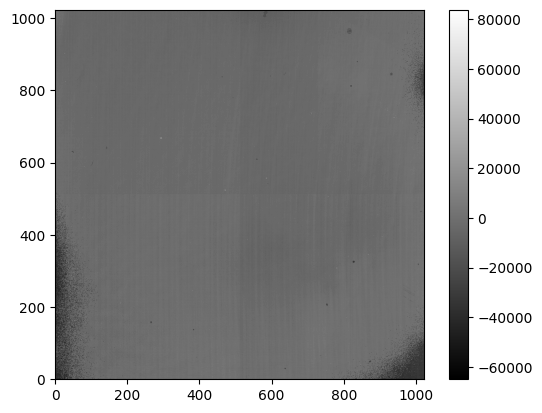

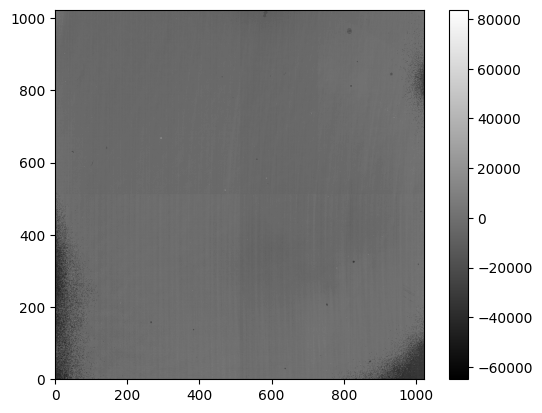

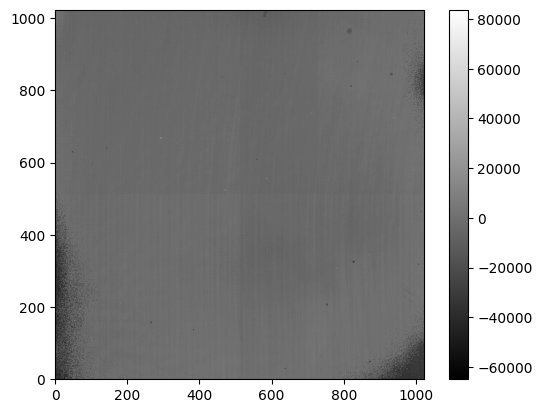

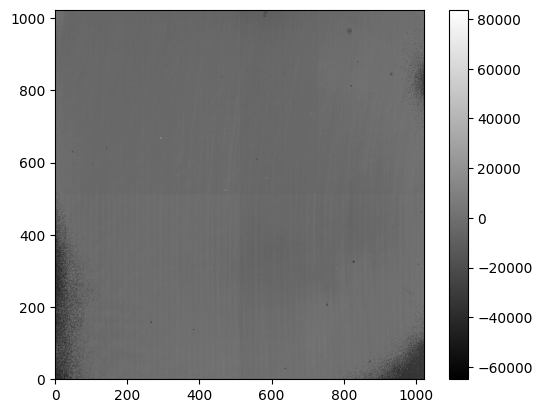

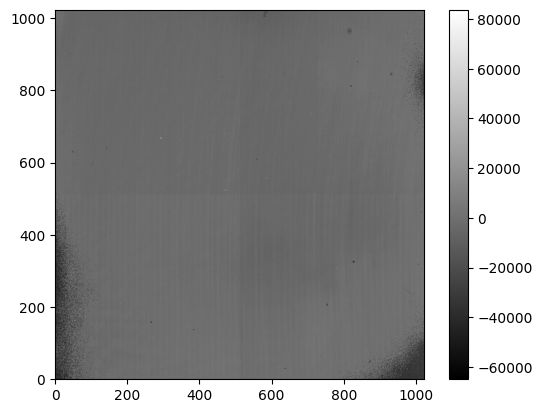

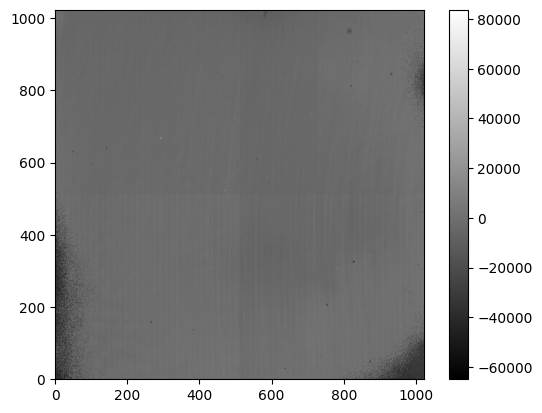

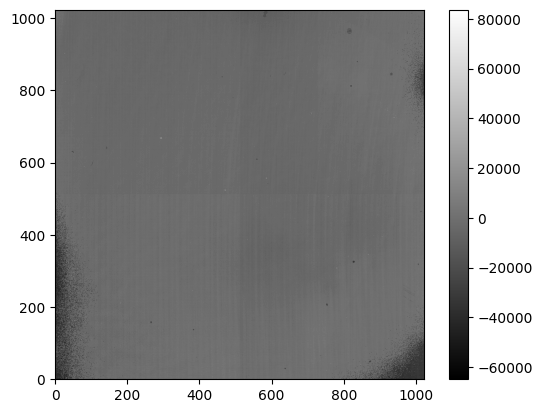

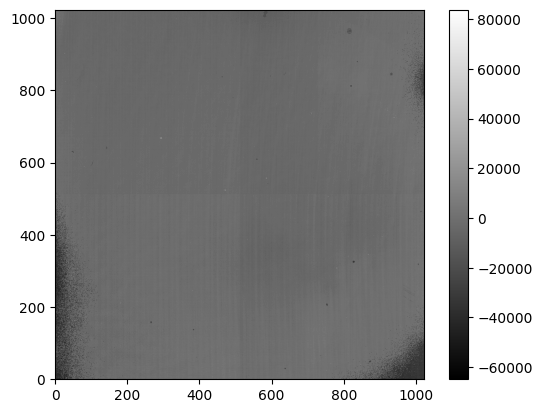

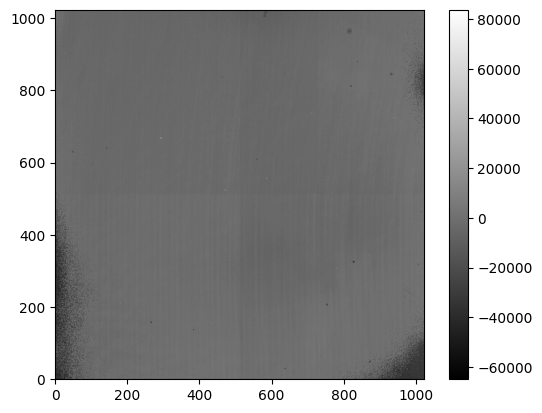

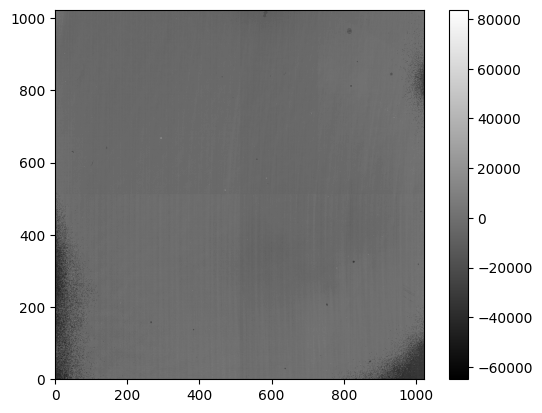

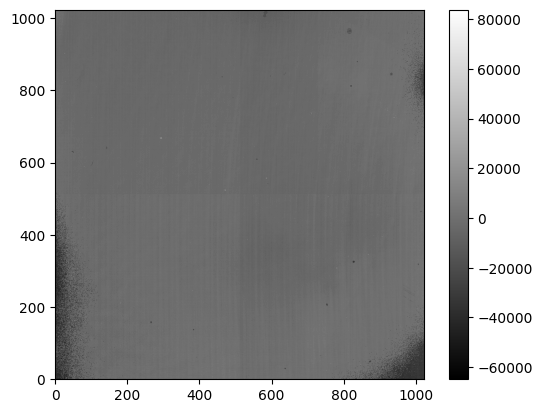

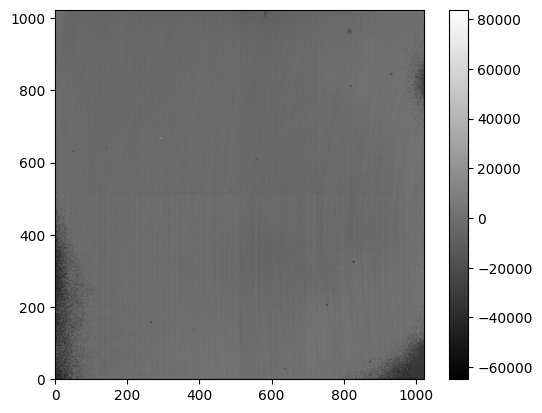

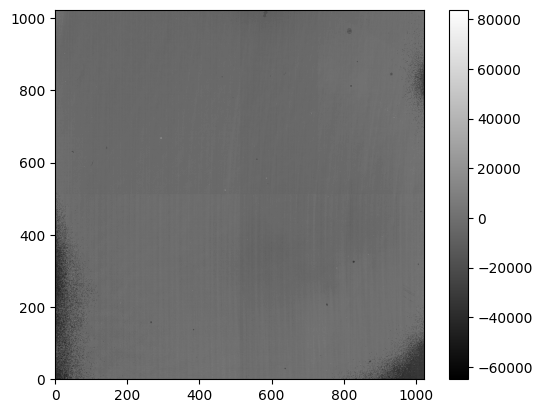

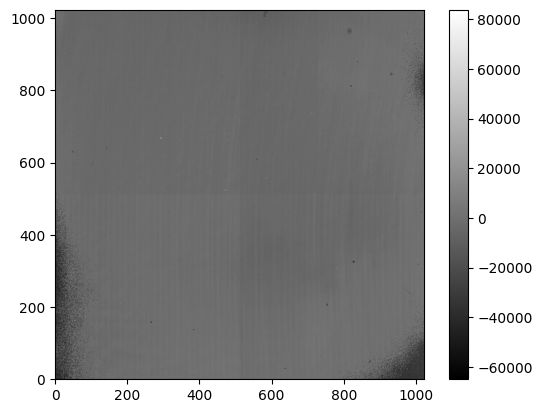

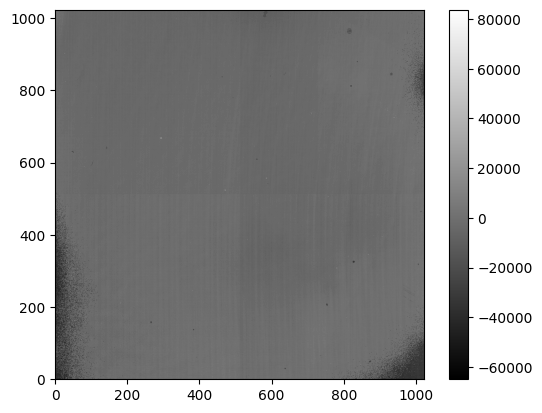

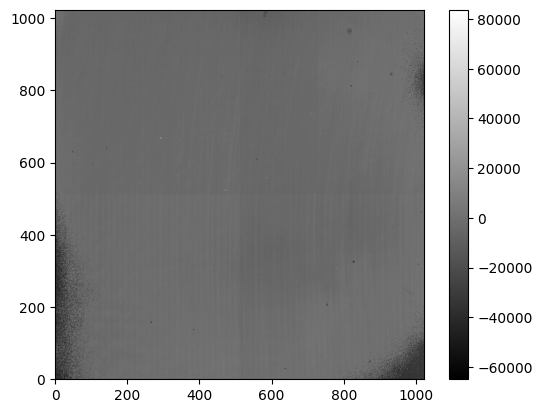

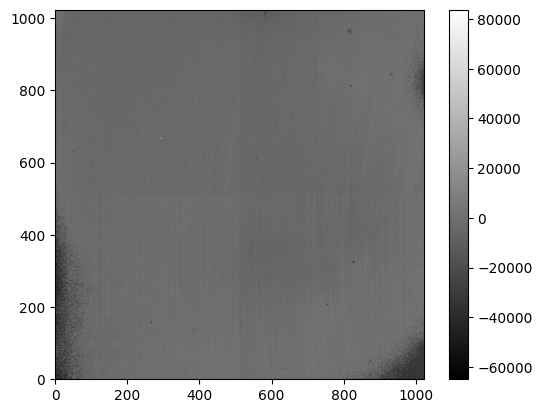

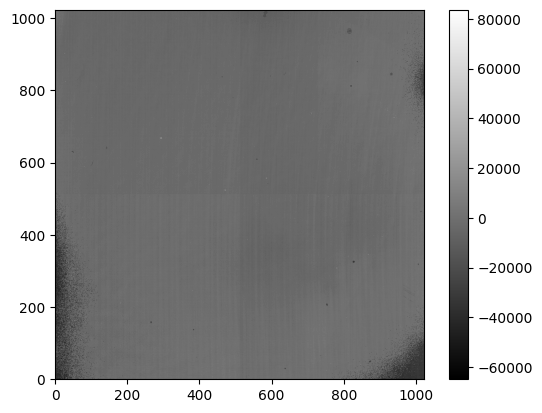

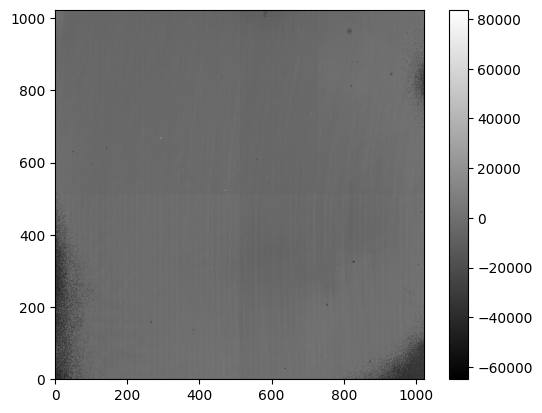

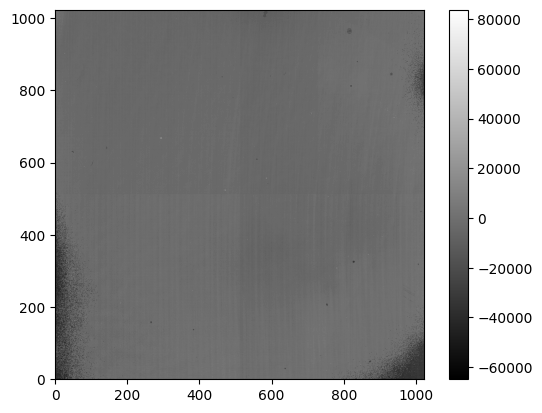

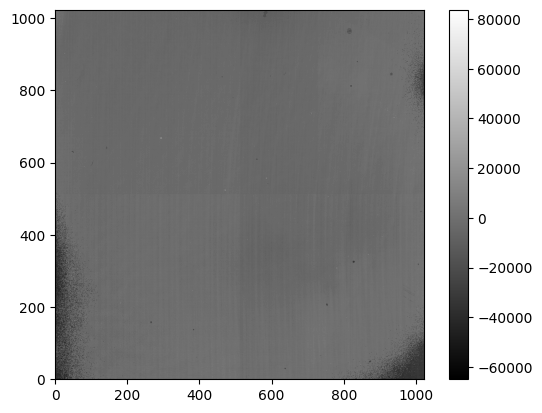

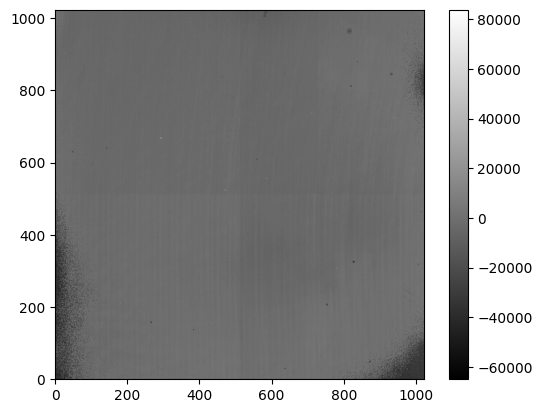

In [17]:
sci_array = sci - sci_darks_master
for i in sci_array:
    plt.imshow(i, origin='lower', cmap='gray')
    plt.colorbar()
    plt.show()
sci_master = np.median(sci_array, axis = 0)

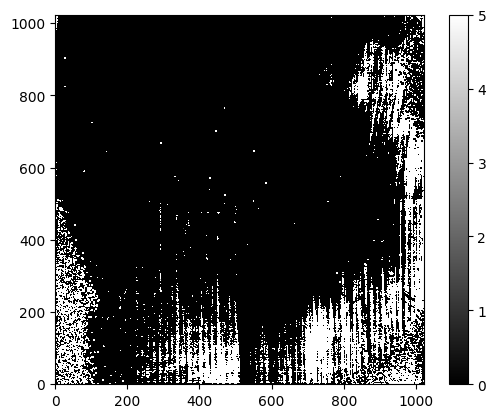

In [52]:
plt.imshow(sci_master, origin='lower', cmap='gray', vmin = 0, vmax = 5)
plt.colorbar()
plt.show()

In [53]:
bad_pixel = hot_pixel + cold_pixel
bad_pixel

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

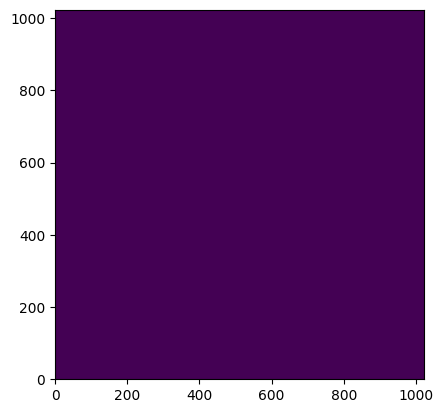

In [54]:
plt.imshow(bad_pixel, origin = "lower")

In [42]:
sci_cube = []
for i in sci_array:
    i -= sci_master
    i[bad_pixel] = np.nan
    sci_cube.append(i)
sci_cube = np.asarray(sci_cube)

/tmp/ipykernel_118451/270270956.py:3: RuntimeWarning: invalid value encountered in subtract
  i -= sci_master


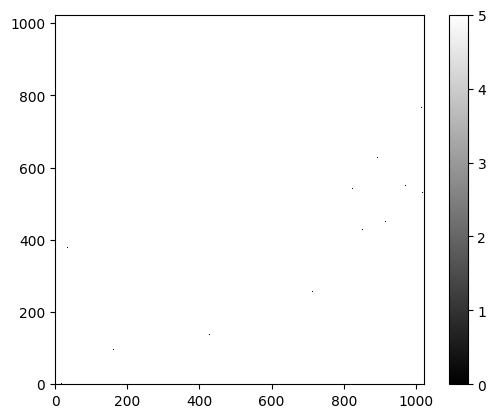

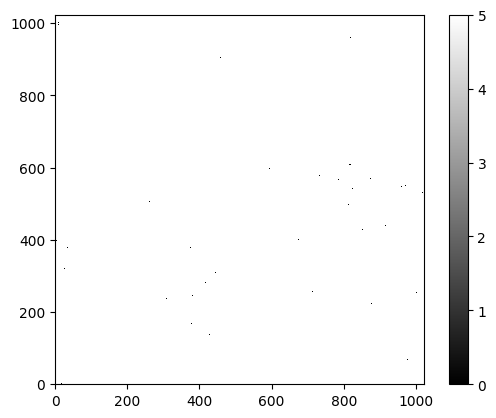

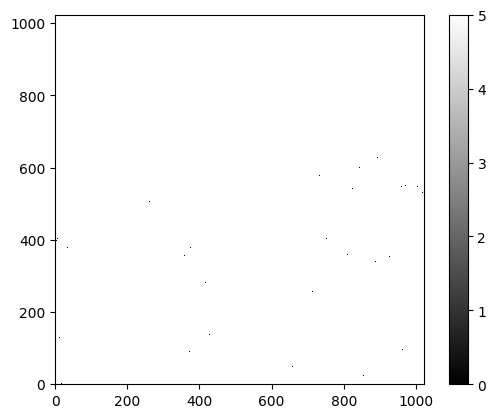

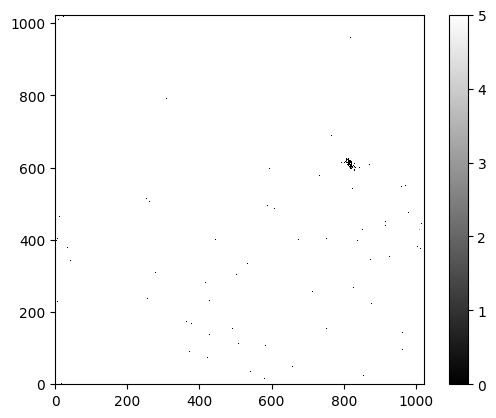

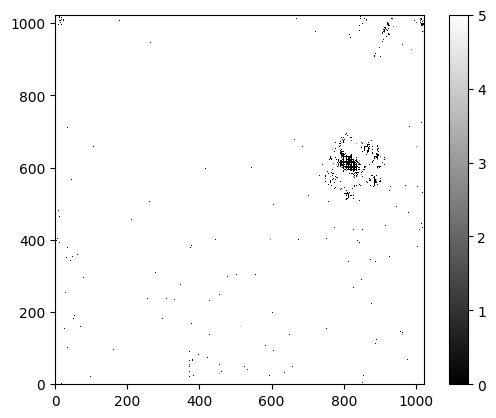

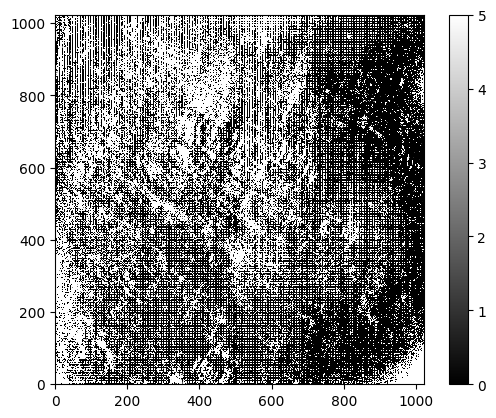

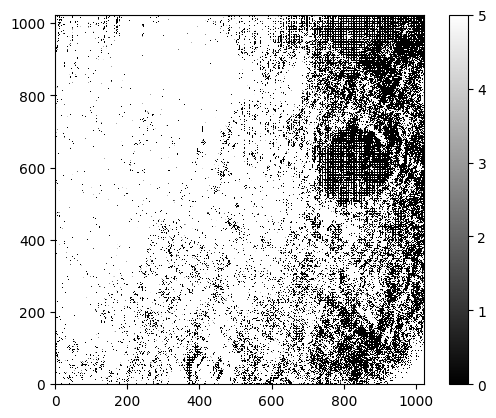

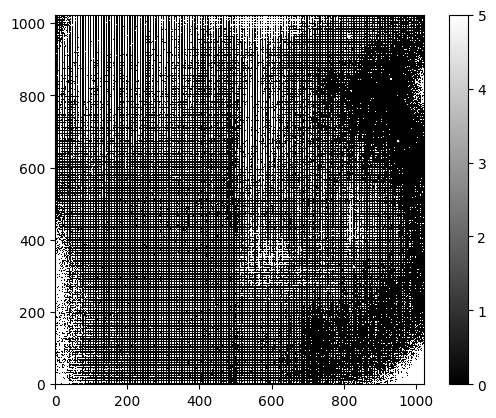

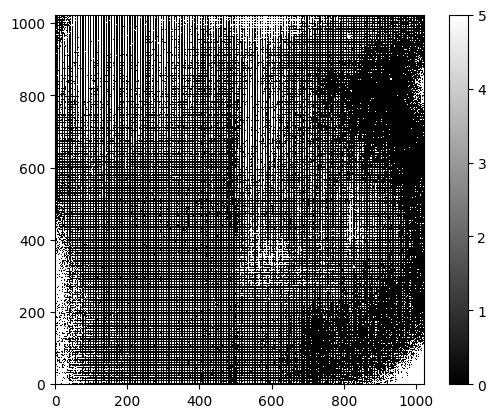

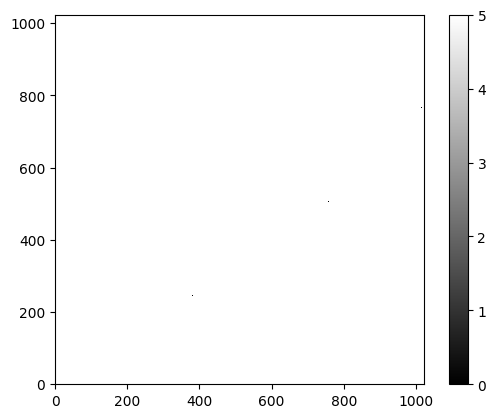

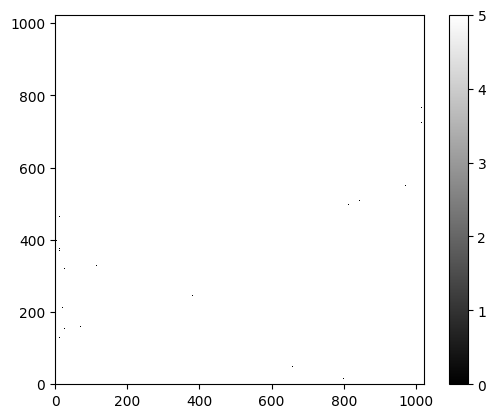

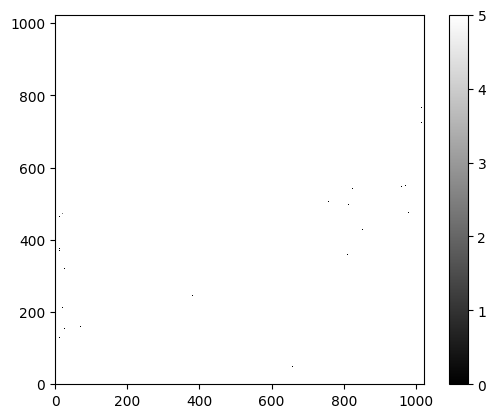

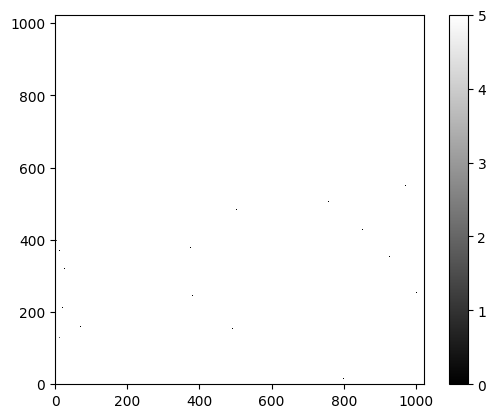

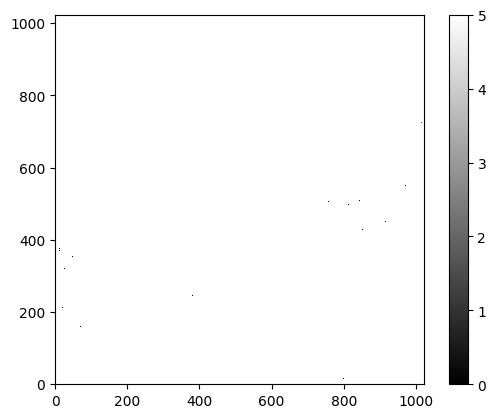

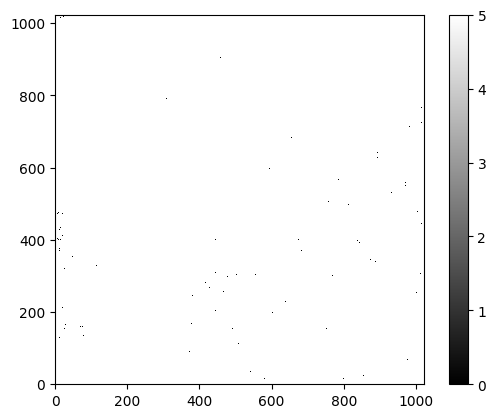

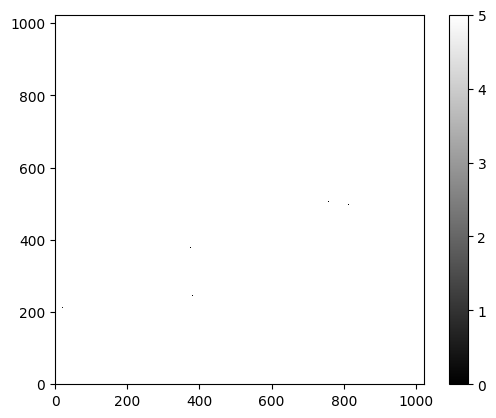

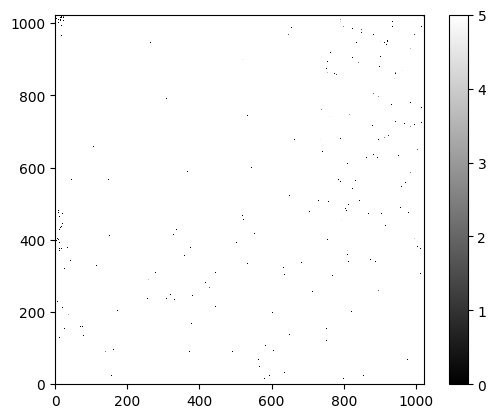

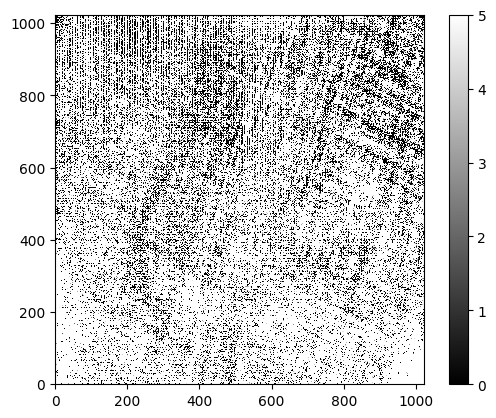

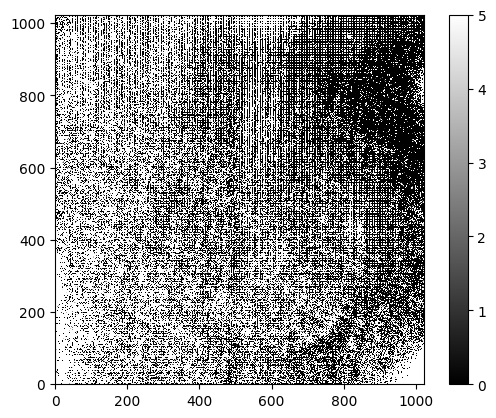

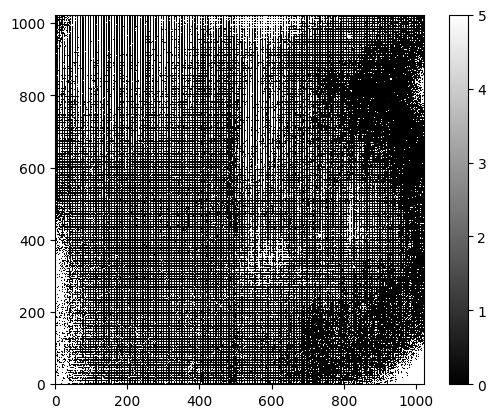

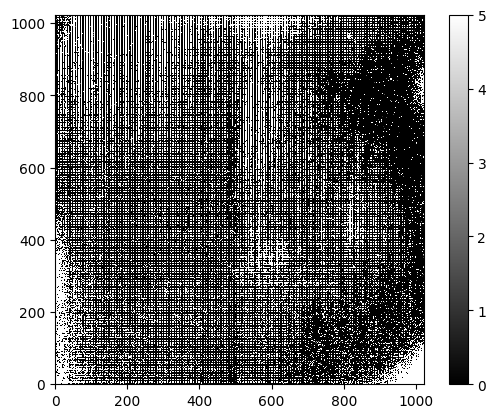

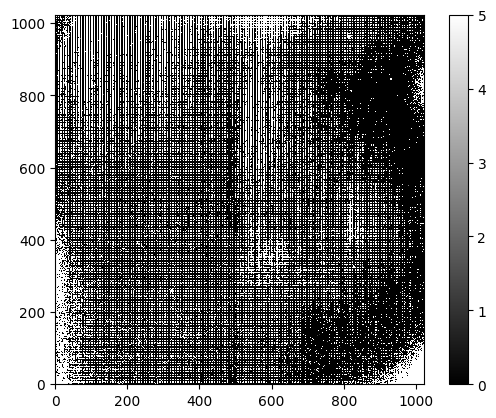

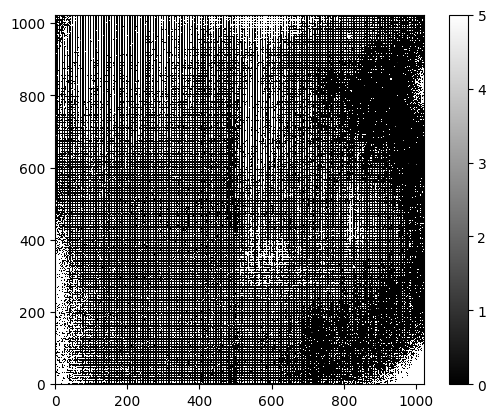

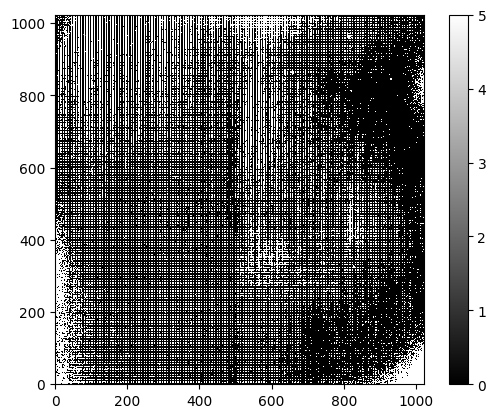

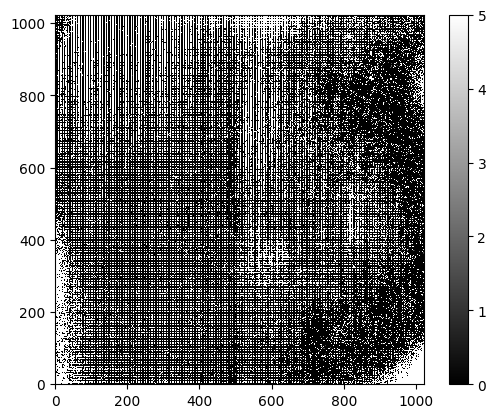

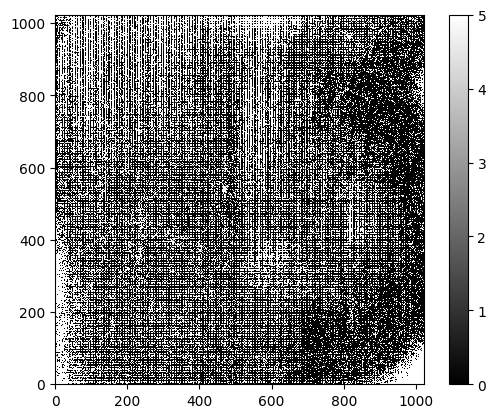

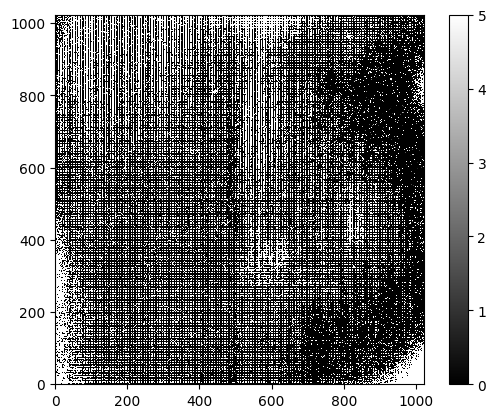

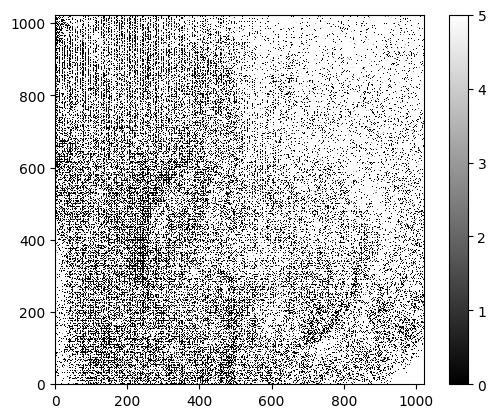

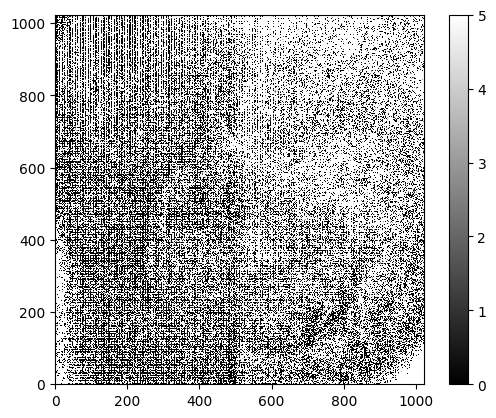

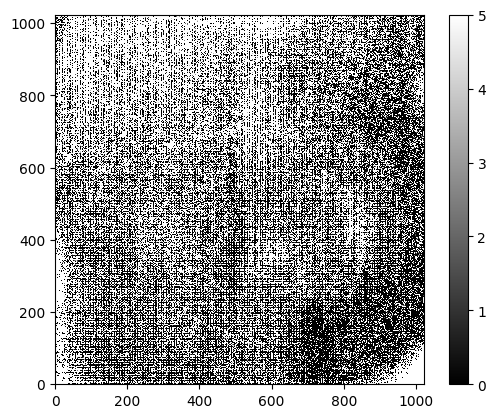

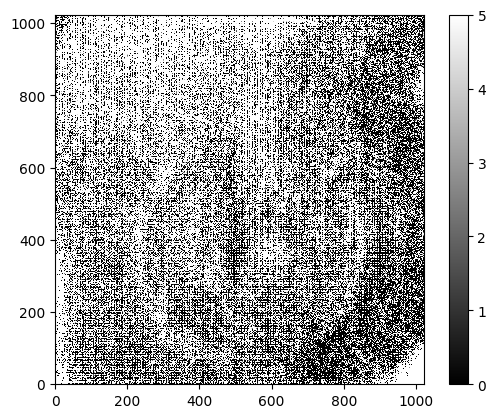

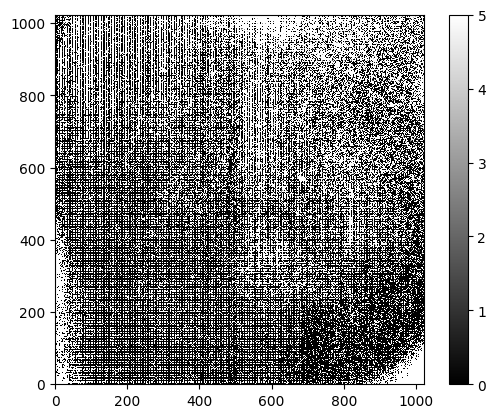

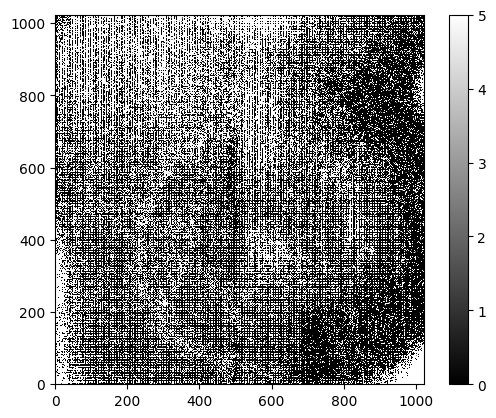

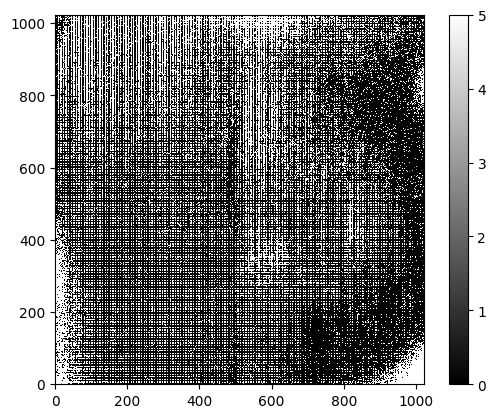

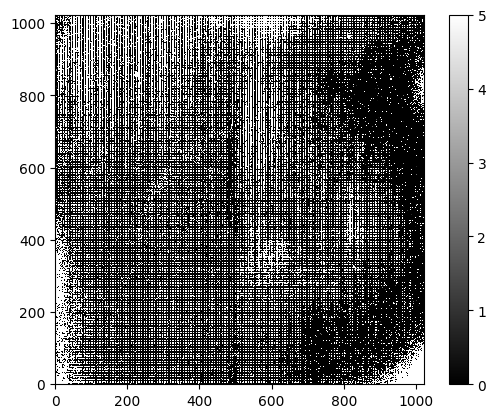

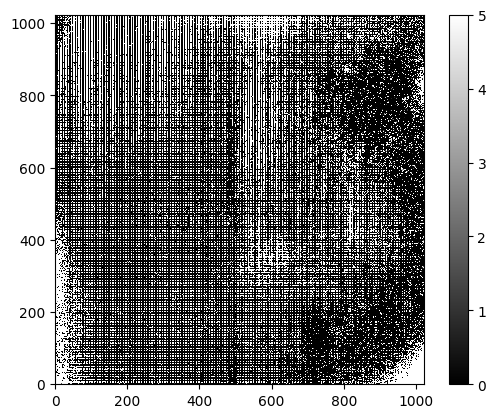

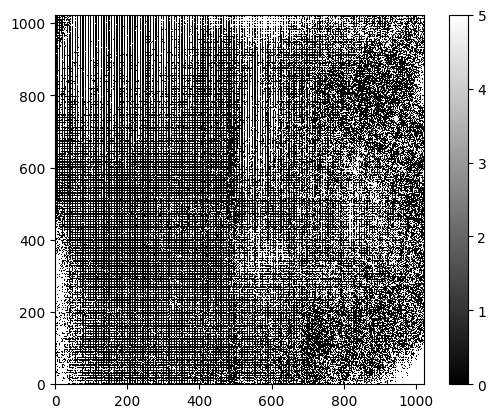

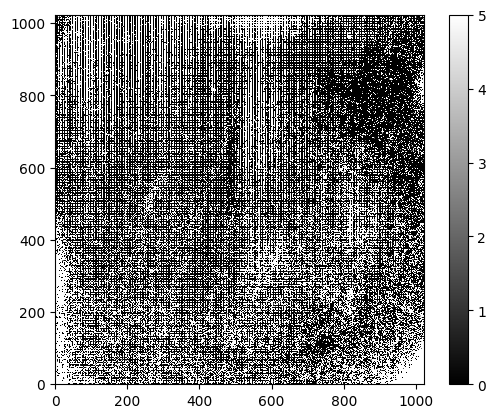

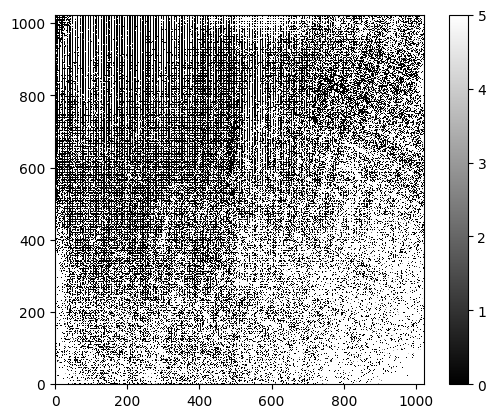

In [43]:
for i in sci_cube:
    plt.imshow(i, origin='lower', cmap='gray', vmin = 0, vmax = 5, interpolation = "nearest")
    plt.colorbar()
    plt.show()

In [20]:
sci_cube.shape

(8, 1024, 1024)

In [21]:
sci_header_tmp=[]
shiftx_tmp=[]
shifty_tmp=[]
for filename in filelist_sci:
    hdu = fits.open(filename)[0]
    sci_header_tmp.append(hdu.header) # read headers including pointing offsets
    shiftx_tmp.append(hdu.header['HIERARCH ESO SEQ CUMOFFSETX'])
    shifty_tmp.append(hdu.header['HIERARCH ESO SEQ CUMOFFSETY'])

In [22]:
crop = 768
dimx = sci_cube.shape[1]
dimy = sci_cube.shape[2]
x1 = int((sci_cube.shape[1] - crop)/2)
x2 = int(x1 + crop)
y1 = int((sci_cube.shape[2] - crop)/2)
y2 = int(y1 + crop)
sci_cube_cropped = sci_cube[:,x1:x2,y1:y2]
sci_cube_cropped.shape

(8, 768, 768)

In [23]:
sci_cube_shifted = np.copy(sci_cube_cropped)
for i in range(len(sci_cube_cropped)):
    dummy = sci_cube_cropped[i,:,:]
    print(shiftx_tmp[i],shifty_tmp[i])
    sci_cube_shifted[i,:,:] = shift(dummy,[-shifty_tmp[i],-shiftx_tmp[i]], order=1)

0.0 0.0
197.0 -10.0
-134.0 170.0
210.0 -197.0
0.0 0.0
-169.0 -156.0
159.0 -166.0
196.0 198.0


In [24]:
sci_cube_shiftedb = np.copy(sci_cube_shifted)

cx=int(crop/2)
cy=int(crop/2)
for i in range(len(sci_cube_shiftedb)):
    dummy = sci_cube_shiftedb[i,:,:]
    max_coord = np.unravel_index(np.nanargmax(dummy, axis=None), dummy.shape)
    print(np.unravel_index(np.nanargmax(dummy, axis=None), dummy.shape))
    shiftx = cx-max_coord[0]
    shifty = cy-max_coord[1]
    print(shiftx,shifty)
    sci_cube_shiftedb[i,:,:] = shift(dummy,[shiftx,shifty], order=1)

(482, 492)
-98 -108
(481, 496)
-97 -112
(484, 490)
-100 -106
(479, 496)
-95 -112
(468, 451)
-84 -67
(466, 448)
-82 -64
(739, 561)
-355 -177
(470, 455)
-86 -71


In [25]:
final_image = np.median(sci_cube_shiftedb[0:3,:,:],axis=0)

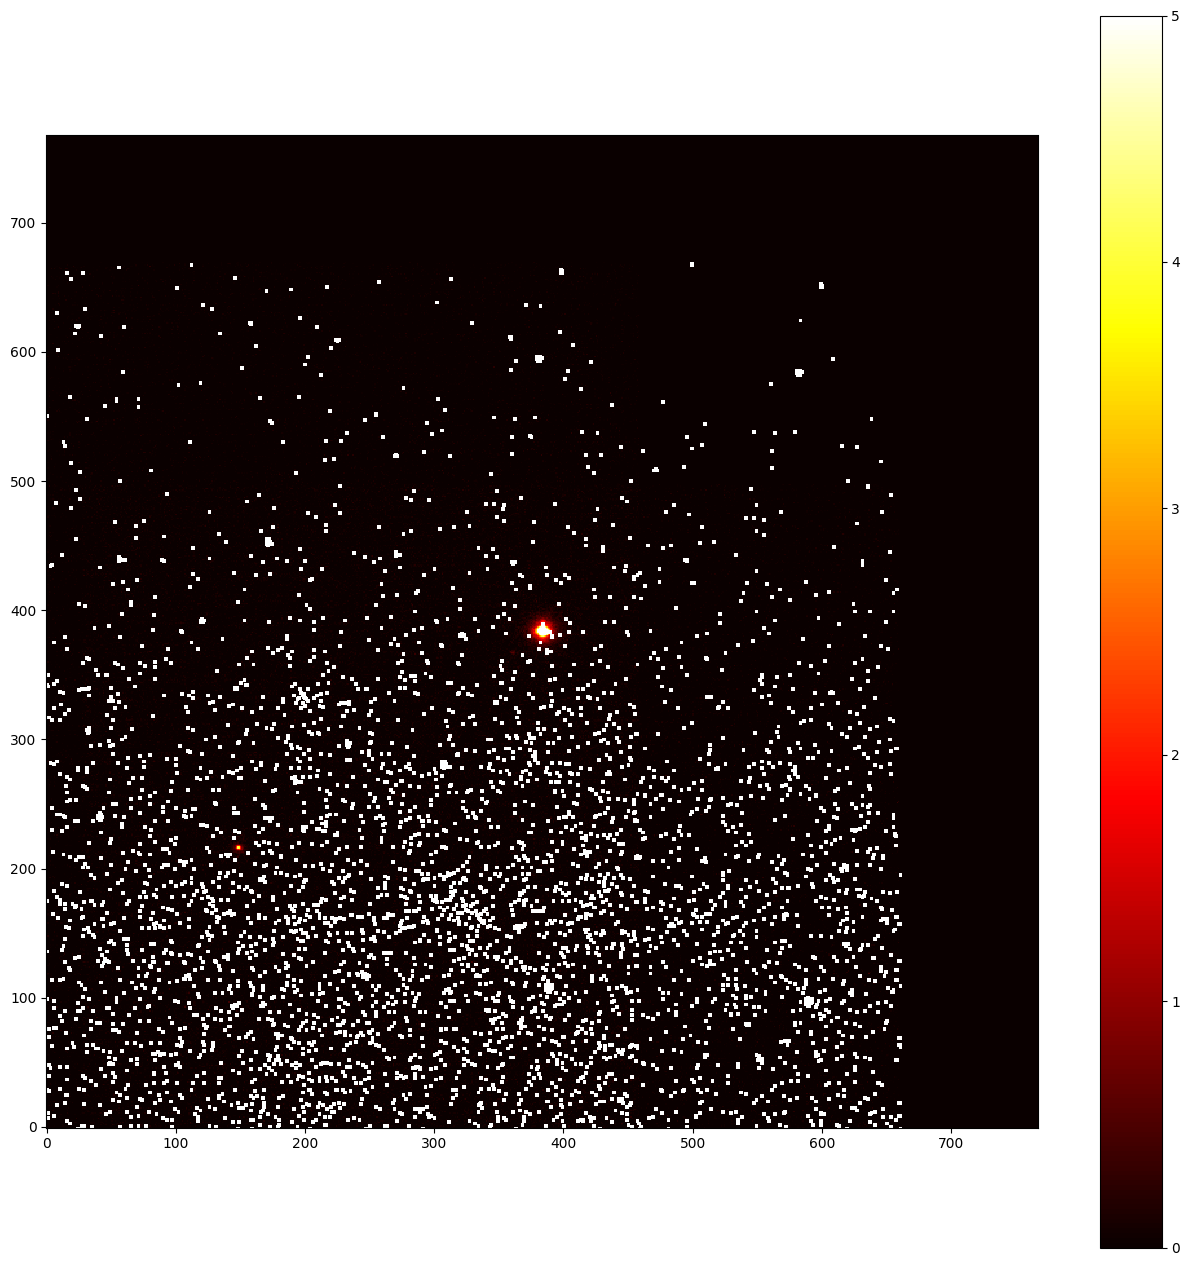

In [26]:
plt.figure(figsize=(16,16))
plt.imshow(final_image,vmin=0,vmax=5,cmap='hot', interpolation = "nearest", origin = "lower")
plt.colorbar()

In [27]:
crop = 128
dimx = final_image.shape[0]
dimy = final_image.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
final_image_cropped = final_image[x1:x2,y1:y2]
final_image_cropped.shape

(128, 128)

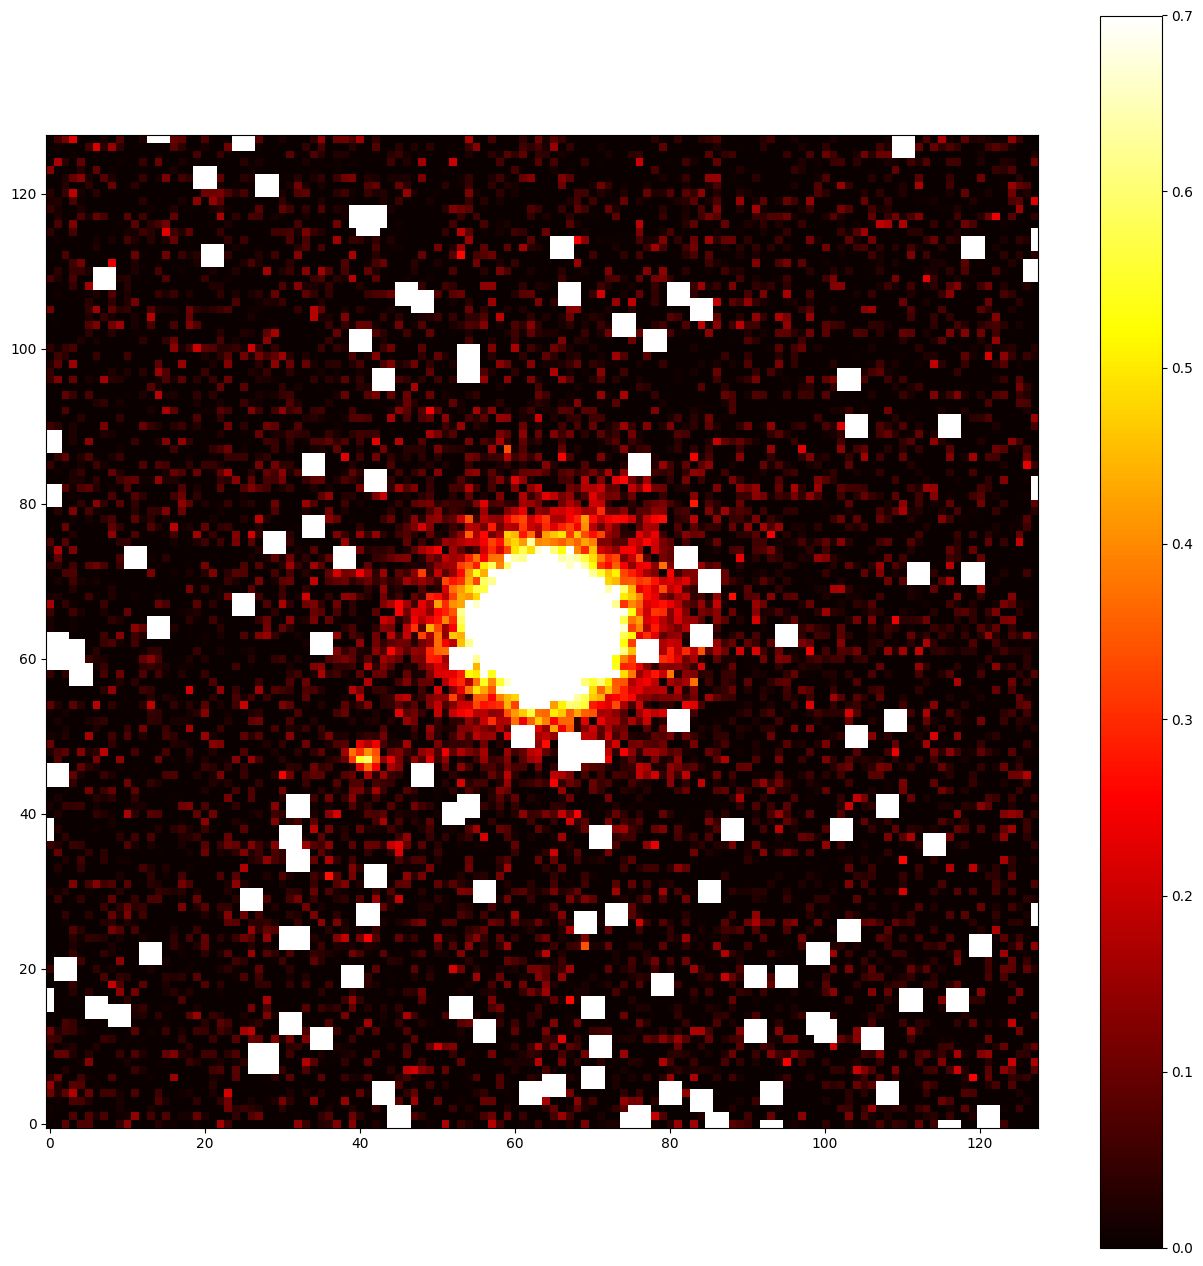

In [28]:
plt.figure(figsize=(16,16))
plt.imshow(final_image_cropped,vmin=0,vmax=0.7,cmap='hot', origin = "lower")
plt.colorbar()

In [29]:
import copy

In [30]:
final_image_cropped_nonan = copy.deepcopy(final_image_cropped)
final_image_cropped_nonan[np.isnan(final_image_cropped)] = np.nanmedian(final_image_cropped)

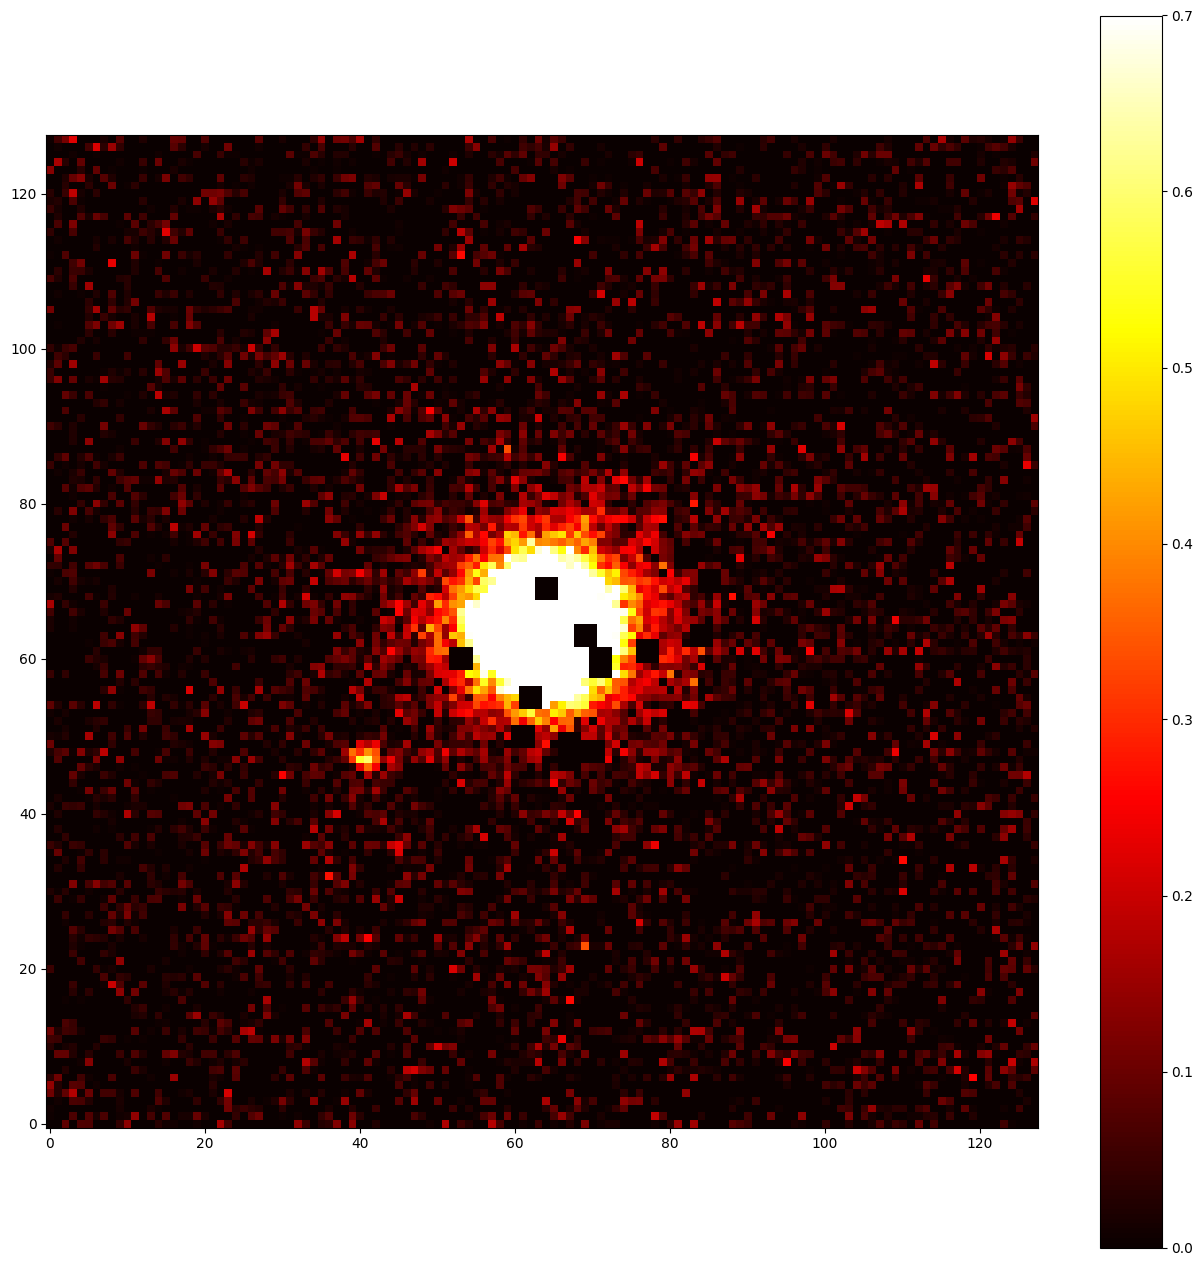

In [31]:
plt.figure(figsize=(16,16))
plt.imshow(final_image_cropped_nonan,vmin=0,vmax=0.7,cmap='hot', origin = "lower")
plt.colorbar()

In [39]:
from photutils import DAOStarFinder
bkg_sigma = np.nanmedian(np.absolute(final_image_cropped - np.nanmedian(final_image_cropped)))
daofind = DAOStarFinder(fwhm=6,threshold=12.*bkg_sigma)  # use 12x background_sigma
sources = daofind(final_image_cropped_nonan)  ## find sources in image
for col in sources.colnames:
    sources[col].info.format = '%.8g' # formatting trick for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky    peak       flux       mag    
--- --------- --------- ---------- ... --- ---------- --------- -----------
  1 40.840613 47.307633 0.70649193 ...   0 0.55302591 1.3664226 -0.33896259
  2 63.736005  63.92222 0.73626132 ...   0  56.370267  130.8625   -5.292038


In [40]:
from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
phot_table = aperture_photometry(final_image_cropped_nonan, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
print('\n')
print(f"Brown Dwarf Aperture Sum: {phot_table['aperture_sum'][0]}")
print(f"Planet Aperture Sum: {phot_table['aperture_sum'][0]}")

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 40.840613 47.307633    6.7391211
  2 63.736005  63.92222    664.48991


Brown Dwarf Aperture Sum: 6.739121120613107
Planet Aperture Sum: 6.739121120613107


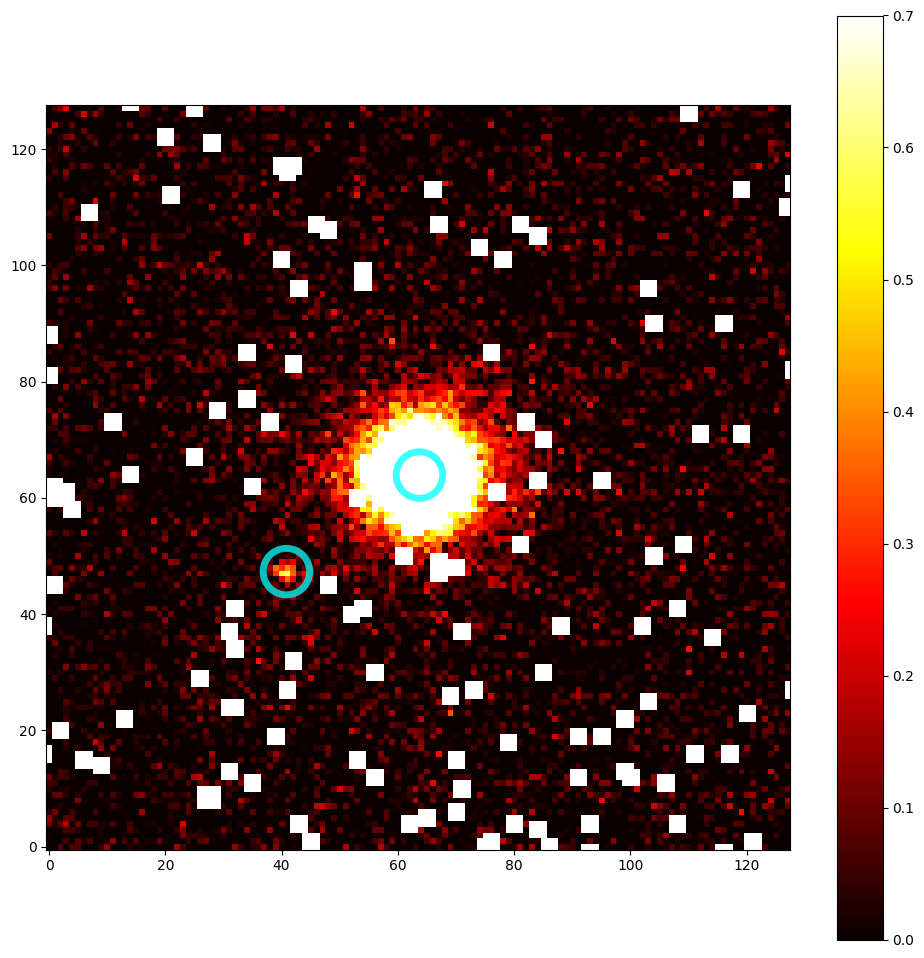

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(final_image_cropped,vmin=0,vmax=0.7,cmap='hot',origin='lower')
apertures.plot(color='cyan',lw=5,alpha=0.75)
plt.colorbar()

In [42]:
#flux_ratio = 16725.869 / 192.28016
flux_ratio = phot_table['aperture_sum'][1] / phot_table['aperture_sum'][0]
print(flux_ratio)

98.60186558622541


In [43]:
mag_difference = 2.5*np.log10(flux_ratio)
print(mag_difference)

4.984712830105015


In [44]:
k_mag_brown_dwarf = 11.945
k_mag_planet = k_mag_brown_dwarf + mag_difference
print(k_mag_planet)

16.929712830105014
